In [1]:
import time

import argparse
import joblib
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
import pickle
# import torch

from collections import Counter
from scipy import stats, cluster

from utils.conformal_utils import *

In [4]:
# Choose settings

alpha = .1
n_totalcal = 20 # Total number of calibration points (= # clustering examples + # conformal calibration examples)
# NOTE: increasing n_totalcal decreases the number of points we can use to compute coverage

# Choose data

# # Enron - BoW 
# softmax_path = "../class-conditional-conformal-datasets/notebooks/.cache/email_softmax_BoW.npy"
# labels_path = "../class-conditional-conformal-datasets/notebooks/.cache/email_labels_BoW.npy"

# # Enron - GloVe
# softmax_path = "../class-conditional-conformal-datasets/.cache/email_softmax_glove.npy"
# labels_path = "../class-conditional-conformal-datasets/.cache/email_labels_glove.npy"

# Enron - BERT
softmax_path = "../class-conditional-conformal-datasets/notebooks/.cache/email_softmax_bert.npy"
labels_path = "../class-conditional-conformal-datasets/notebooks/.cache/email_labels_bert.npy"

# # CIFAR-100
# softmax_path = "../class-conditional-conformal-datasets/notebooks/.cache/best-cifar100-model-valsoftmax_frac=0.3.npy"
# labels_path = "../class-conditional-conformal-datasets/notebooks/.cache/best-cifar100-model-vallabels_frac=0.3.npy"

# Option 1: For a single random seed

In [5]:
print('====== SETTINGS =====')
print(f'alpha={alpha}')
print(f'n_totalcal={n_totalcal}')
print('=====================')

## 1. Get data ============================
print('Loading softmax scores and labels...')

softmax_scores = np.load(softmax_path)
labels = np.load(labels_path)

num_classes = labels.max() + 1

for score_function in ['softmax', 'APS', 'RAPS']:
    
    print(f'====== score_function={score_function} ======')
    
    print('Computing conformal score...')
    if score_function == 'softmax':
        scores_all = 1 - softmax_scores
    elif score_function == 'APS':
        scores_all = get_APS_scores_all(softmax_scores, randomize=True)
    elif score_function == 'RAPS': 
        
        # RAPS hyperparameters (currently using ImageNet defaults)
        lmbda = .01 
        kreg = 5
        
        scores_all = get_RAPS_scores_all(softmax_scores, lmbda, kreg, randomize=True)
    else:
        raise Exception('Undefined score function')


    print('Splitting data...')
    # Split into clustering+calibration data and validation data
    totalcal_scores_all, totalcal_labels, val_scores_all, val_labels = split_X_and_y(scores_all, labels, n_totalcal, num_classes=num_classes, seed=0)


## 2. Compute baselines for evaluation ============================

    print('Evaluating baselines...')
    # A) Vanilla conformal
    vanilla_qhat = compute_qhat(totalcal_scores_all, totalcal_labels, alpha=alpha)
    vanilla_preds = create_prediction_sets(val_scores_all, vanilla_qhat)

    marginal_cov = compute_coverage(val_labels, vanilla_preds)
    print(f'Marginal coverage of Vanilla: {marginal_cov*100:.2f}%')
    vanilla_class_specific_cov = compute_class_specific_coverage(val_labels, vanilla_preds)

    # B) Naive class-balanced
    naivecb_qhats = compute_class_specific_qhats(totalcal_scores_all, totalcal_labels, alpha=alpha, default_qhat=np.inf)
    naivecb_preds = create_cb_prediction_sets(val_scores_all, naivecb_qhats)

    naivecb_marginal_cov = compute_coverage(val_labels, naivecb_preds)
    print(f'Marginal coverage of NaiveCC: {naivecb_marginal_cov*100:.2f}%')
    naivecb_class_specific_cov = compute_class_specific_coverage(val_labels, naivecb_preds)

    # CC coverage
    vanilla_l1_dist = np.mean(np.abs(vanilla_class_specific_cov - (1 - alpha)))
    naivecb_l1_dist = np.mean(np.abs(naivecb_class_specific_cov - (1 - alpha)))

    print(f'[Vanilla] Average class-coverage gap: {vanilla_l1_dist*100:.3f}')
    print(f'[NaiveCC] Average class-coverage gap: {naivecb_l1_dist*100:.3f}')
    
    ## Set size
    vanilla_set_sizes = [len(x) for x in vanilla_preds]
    vanilla_set_size_metrics = {'mean': np.mean(vanilla_set_sizes), '[.25, .5, .75, .9] quantiles': np.quantile(vanilla_set_sizes, [.25, .5, .75, .9])}
    naivecb_set_sizes = [len(x) for x in naivecb_preds]
    naivecb_set_size_metrics = {'mean': np.mean(naivecb_set_sizes), '[.25, .5, .75, .9] quantiles': np.quantile(naivecb_set_sizes, [.25, .5, .75, .9])}
    print(f'[Vanilla] set size metrics:', vanilla_set_size_metrics)
    print(f'[NaiveCC] set size metrics:', naivecb_set_size_metrics)

====== SETTINGS =====
alpha=0.1
n_totalcal=20
Loading softmax scores and labels...
====== score_function=softmax ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 90.04%
Marginal coverage of NaiveCC: 91.72%
[Vanilla] Average class-coverage gap: 1.905
[NaiveCC] Average class-coverage gap: 4.790
[Vanilla] set size metrics: {'mean': 36.560241069747, '[.25, .5, .75, .9] quantiles': array([29., 39., 47., 52.])}
[NaiveCC] set size metrics: {'mean': 45.25335928181305, '[.25, .5, .75, .9] quantiles': array([38., 49., 56., 61.])}
====== score_function=APS ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 89.88%
Marginal coverage of NaiveCC: 91.65%
[Vanilla] Average class-coverage gap: 1.948
[NaiveCC] Average class-coverage gap: 4.767
[Vanilla] set size metrics: {'mean': 37.31397576746814, '[.25, .5, .75, .9] quantiles': array([30., 41., 48., 53.])}
[NaiveCC] set size metrics: {'me

In [ ]:
# ENRON 

'''
-------- BoW embeddings -------- 

====== SETTINGS =====
n_totalcal = 10
Loading softmax scores and labels...
====== score_function=softmax ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 90.15%
Marginal coverage of NaiveCC: 91.17%
[Vanilla] L1 distance between desired and realized class-cond. coverage: 6.342
[NaiveCC] L1 distance between desired and realized class-cond. coverage: 7.426
Note: The average magnitude of deviation from the desired coverage is L1 dist/1000
[Vanilla] set size metrics: {'mean': 58.68494018378316, '[.25, .5, .75, .9] quantiles': array([51., 62., 69., 74.])}
[NaiveCC] set size metrics: {'mean': 64.16977402762527, '[.25, .5, .75, .9] quantiles': array([58., 68., 74., 78.])}
====== score_function=APS ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 89.27%
Marginal coverage of NaiveCC: 90.77%
[Vanilla] L1 distance between desired and realized class-cond. coverage: 6.927
[NaiveCC] L1 distance between desired and realized class-cond. coverage: 7.888
Note: The average magnitude of deviation from the desired coverage is L1 dist/1000
[Vanilla] set size metrics: {'mean': 56.52613304051321, '[.25, .5, .75, .9] quantiles': array([56., 59., 60., 61.])}
[NaiveCC] set size metrics: {'mean': 64.58115008957984, '[.25, .5, .75, .9] quantiles': array([62., 66., 70., 73.])}
====== score_function=RAPS ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 89.46%
Marginal coverage of NaiveCC: 90.68%
[Vanilla] L1 distance between desired and realized class-cond. coverage: 6.981
[NaiveCC] L1 distance between desired and realized class-cond. coverage: 8.155
Note: The average magnitude of deviation from the desired coverage is L1 dist/1000
[Vanilla] set size metrics: {'mean': 57.007580188406635, '[.25, .5, .75, .9] quantiles': array([57., 58., 58., 59.])}
[NaiveCC] set size metrics: {'mean': 64.05058775934809, '[.25, .5, .75, .9] quantiles': array([61., 65., 68., 71.])}

Increasing n_totalcal does not have much of an effect

-------- GloVE embeddings -------- 

====== SETTINGS =====
alpha=0.1
n_totalcal=100
=====================
Loading softmax scores and labels...
====== score_function=softmax ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 89.83%
Marginal coverage of NaiveCC: 89.88%
[Vanilla] Average class-coverage gap: 2.880
[NaiveCC] Average class-coverage gap: 3.269
[Vanilla] set size metrics: {'mean': 40.52667016685662, '[.25, .5, .75, .9] quantiles': array([26., 43., 56., 65.])}
[NaiveCC] set size metrics: {'mean': 42.123614757142306, '[.25, .5, .75, .9] quantiles': array([28., 46., 57., 66.])}
====== score_function=APS ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 89.81%
Marginal coverage of NaiveCC: 89.71%
[Vanilla] Average class-coverage gap: 2.908
[NaiveCC] Average class-coverage gap: 3.269
[Vanilla] set size metrics: {'mean': 45.82951940684586, '[.25, .5, .75, .9] quantiles': array([30., 52., 64., 71.])}
[NaiveCC] set size metrics: {'mean': 46.83192685456711, '[.25, .5, .75, .9] quantiles': array([32., 53., 64., 71.])}
====== score_function=RAPS ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 89.99%
Marginal coverage of NaiveCC: 90.04%
[Vanilla] Average class-coverage gap: 2.876
[NaiveCC] Average class-coverage gap: 3.378
[Vanilla] set size metrics: {'mean': 42.630730814050274, '[.25, .5, .75, .9] quantiles': array([37., 44., 48., 51.])}
[NaiveCC] set size metrics: {'mean': 44.66073427155498, '[.25, .5, .75, .9] quantiles': array([40., 46., 50., 53.])}

-------- BERT embeddings --------

====== SETTINGS =====
alpha=0.1
n_totalcal=100
=====================
Loading softmax scores and labels...
====== score_function=softmax ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 90.02%
Marginal coverage of NaiveCC: 90.75%
[Vanilla] Average class-coverage gap: 2.042
[NaiveCC] Average class-coverage gap: 2.266
[Vanilla] set size metrics: {'mean': 36.464243077752535, '[.25, .5, .75, .9] quantiles': array([29., 39., 47., 52.])}
[NaiveCC] set size metrics: {'mean': 38.024790439147125, '[.25, .5, .75, .9] quantiles': array([30., 41., 48., 54.])}
====== score_function=APS ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 90.08%
Marginal coverage of NaiveCC: 90.63%
[Vanilla] Average class-coverage gap: 1.991
[NaiveCC] Average class-coverage gap: 2.093
[Vanilla] set size metrics: {'mean': 37.867757795150254, '[.25, .5, .75, .9] quantiles': array([30., 41., 49., 54.])}
[NaiveCC] set size metrics: {'mean': 39.29886137533536, '[.25, .5, .75, .9] quantiles': array([32., 43., 50., 55.])}
====== score_function=RAPS ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 90.30%
Marginal coverage of NaiveCC: 90.74%
[Vanilla] Average class-coverage gap: 1.994
[NaiveCC] Average class-coverage gap: 2.140
[Vanilla] set size metrics: {'mean': 42.574855265015856, '[.25, .5, .75, .9] quantiles': array([40., 43., 46., 48.])}
[NaiveCC] set size metrics: {'mean': 43.94712006264361, '[.25, .5, .75, .9] quantiles': array([41., 44., 47., 50.])}



====== SETTINGS =====
alpha=0.1
n_totalcal=10
=====================
Loading softmax scores and labels...
====== score_function=softmax ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 89.98%
Marginal coverage of NaiveCC: 90.21%
[Vanilla] Average class-coverage gap: 1.950
[NaiveCC] Average class-coverage gap: 6.689
[Vanilla] set size metrics: {'mean': 36.35996393824424, '[.25, .5, .75, .9] quantiles': array([28., 39., 46., 52.])}
[NaiveCC] set size metrics: {'mean': 47.23285376206754, '[.25, .5, .75, .9] quantiles': array([41., 51., 57., 62.])}
====== score_function=APS ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 89.78%
Marginal coverage of NaiveCC: 89.81%
[Vanilla] Average class-coverage gap: 2.026
[NaiveCC] Average class-coverage gap: 6.570
[Vanilla] set size metrics: {'mean': 37.01091118540501, '[.25, .5, .75, .9] quantiles': array([30., 40., 48., 53.])}
[NaiveCC] set size metrics: {'mean': 48.94149981843908, '[.25, .5, .75, .9] quantiles': array([43., 52., 58., 63.])}
====== score_function=RAPS ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 90.28%
Marginal coverage of NaiveCC: 90.08%
[Vanilla] Average class-coverage gap: 1.925
[NaiveCC] Average class-coverage gap: 6.474
[Vanilla] set size metrics: {'mean': 42.515172232448066, '[.25, .5, .75, .9] quantiles': array([40., 43., 46., 48.])}
[NaiveCC] set size metrics: {'mean': 52.44974518863554, '[.25, .5, .75, .9] quantiles': array([50., 53., 56., 58.])}

====== SETTINGS =====
alpha=0.1
n_totalcal=20
=====================
Loading softmax scores and labels...
====== score_function=softmax ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 90.04%
Marginal coverage of NaiveCC: 91.72%
[Vanilla] Average class-coverage gap: 1.905
[NaiveCC] Average class-coverage gap: 4.790
[Vanilla] set size metrics: {'mean': 36.560241069747, '[.25, .5, .75, .9] quantiles': array([29., 39., 47., 52.])}
[NaiveCC] set size metrics: {'mean': 45.25335928181305, '[.25, .5, .75, .9] quantiles': array([38., 49., 56., 61.])}
====== score_function=APS ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 89.88%
Marginal coverage of NaiveCC: 91.65%
[Vanilla] Average class-coverage gap: 1.948
[NaiveCC] Average class-coverage gap: 4.767
[Vanilla] set size metrics: {'mean': 37.31397576746814, '[.25, .5, .75, .9] quantiles': array([30., 41., 48., 53.])}
[NaiveCC] set size metrics: {'mean': 46.7664636825915, '[.25, .5, .75, .9] quantiles': array([40., 50., 57., 62.])}
====== score_function=RAPS ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 90.43%
Marginal coverage of NaiveCC: 91.86%
[Vanilla] Average class-coverage gap: 1.914
[NaiveCC] Average class-coverage gap: 4.945
[Vanilla] set size metrics: {'mean': 43.11203716491933, '[.25, .5, .75, .9] quantiles': array([41., 44., 46., 48.])}
[NaiveCC] set size metrics: {'mean': 51.28442965660117, '[.25, .5, .75, .9] quantiles': array([48., 52., 55., 57.])}
'''
None


In [ ]:
# CIFAR-100
'''
====== SETTINGS =====
alpha=0.1
n_totalcal=10
=====================
Loading softmax scores and labels...
====== score_function=softmax ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 91.85%
Marginal coverage of NaiveCC: 91.09%
[Vanilla] Average class-coverage gap: 4.049
[NaiveCC] Average class-coverage gap: 8.071
[Vanilla] set size metrics: {'mean': 8.02764705882353, '[.25, .5, .75, .9] quantiles': array([ 1.,  4., 11., 21.])}
[NaiveCC] set size metrics: {'mean': 24.23029411764706, '[.25, .5, .75, .9] quantiles': array([14., 21., 32., 43.])}
====== score_function=APS ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 91.95%
Marginal coverage of NaiveCC: 90.66%
[Vanilla] Average class-coverage gap: 3.825
[NaiveCC] Average class-coverage gap: 8.175
[Vanilla] set size metrics: {'mean': 11.498117647058823, '[.25, .5, .75, .9] quantiles': array([ 1.,  4., 16., 35.])}
[NaiveCC] set size metrics: {'mean': 26.020470588235295, '[.25, .5, .75, .9] quantiles': array([13., 23., 36., 49.])}
====== score_function=RAPS ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 91.44%
Marginal coverage of NaiveCC: 90.67%
[Vanilla] Average class-coverage gap: 4.715
[NaiveCC] Average class-coverage gap: 8.043
[Vanilla] set size metrics: {'mean': 7.58535294117647, '[.25, .5, .75, .9] quantiles': array([7., 7., 8., 9.])}
[NaiveCC] set size metrics: {'mean': 18.80641176470588, '[.25, .5, .75, .9] quantiles': array([17., 19., 21., 22.])}




====== SETTINGS =====
alpha=0.1
n_totalcal=20
=====================
Loading softmax scores and labels...
====== score_function=softmax ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 90.75%
Marginal coverage of NaiveCC: 91.05%
[Vanilla] Average class-coverage gap: 3.884
[NaiveCC] Average class-coverage gap: 5.392
[Vanilla] set size metrics: {'mean': 6.823625, '[.25, .5, .75, .9] quantiles': array([ 1.,  3.,  9., 18.])}
[NaiveCC] set size metrics: {'mean': 12.7353125, '[.25, .5, .75, .9] quantiles': array([ 4.,  9., 18., 29.])}
====== score_function=APS ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 90.60%
Marginal coverage of NaiveCC: 91.07%
[Vanilla] Average class-coverage gap: 3.911
[NaiveCC] Average class-coverage gap: 5.007
[Vanilla] set size metrics: {'mean': 9.5258125, '[.25, .5, .75, .9] quantiles': array([ 1.,  3., 12., 29.])}
[NaiveCC] set size metrics: {'mean': 15.344875, '[.25, .5, .75, .9] quantiles': array([ 4., 10., 23., 38.])}
====== score_function=RAPS ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 90.78%
Marginal coverage of NaiveCC: 91.59%
[Vanilla] Average class-coverage gap: 4.786
[NaiveCC] Average class-coverage gap: 5.196
[Vanilla] set size metrics: {'mean': 6.7675, '[.25, .5, .75, .9] quantiles': array([6., 6., 7., 8.])}
[NaiveCC] set size metrics: {'mean': 12.8803125, '[.25, .5, .75, .9] quantiles': array([11., 13., 15., 16.])}




====== SETTINGS =====
alpha=0.1
n_totalcal=100
=====================
Loading softmax scores and labels...
====== score_function=softmax ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 90.30%
Marginal coverage of NaiveCC: 90.39%
[Vanilla] Average class-coverage gap: 3.978
[NaiveCC] Average class-coverage gap: 3.180
[Vanilla] set size metrics: {'mean': 6.286875, '[.25, .5, .75, .9] quantiles': array([ 1.,  3.,  8., 17.])}
[NaiveCC] set size metrics: {'mean': 8.093625, '[.25, .5, .75, .9] quantiles': array([ 1.,  4., 12., 22.])}
====== score_function=APS ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 90.20%
Marginal coverage of NaiveCC: 90.51%
[Vanilla] Average class-coverage gap: 4.018
[NaiveCC] Average class-coverage gap: 2.944
[Vanilla] set size metrics: {'mean': 8.964375, '[.25, .5, .75, .9] quantiles': array([ 1.,  3., 11., 28.])}
[NaiveCC] set size metrics: {'mean': 10.829125, '[.25, .5, .75, .9] quantiles': array([ 1. ,  4.5, 16. , 31. ])}
====== score_function=RAPS ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 90.59%
Marginal coverage of NaiveCC: 90.54%
[Vanilla] Average class-coverage gap: 5.298
[NaiveCC] Average class-coverage gap: 3.236
[Vanilla] set size metrics: {'mean': 6.487625, '[.25, .5, .75, .9] quantiles': array([6., 6., 6., 8.])}
[NaiveCC] set size metrics: {'mean': 9.014125, '[.25, .5, .75, .9] quantiles': array([ 7.,  9., 11., 12.])}
'''
None

BoW embeddings yield average set size of 60. GloVe embeddings yield average set size in the 40s. Better, but still too large to be practically useful I think

# Option 2: Averaged over multiple random seeds

In [8]:
def _print_metrics(metrics):
    for m in ['marginal_cov', 'avg_class_cov_gap', 'avg_set_size']:
        arr = metrics[m]
        if 'cov' in m: # scale coverage metrics to % scale
            arr = arr * 100

        print(f'{m}: {np.mean(arr)} ({np.std(arr) / np.sqrt(len(arr)-1)})')

def compute_baselines(scores_all, labels, 
                      n_totalcal, alpha,
                      seeds=[0,1,2,3,4]):
    
    vanilla_metrics = {'marginal_cov': np.zeros((len(seeds),)),
                       'avg_class_cov_gap': np.zeros((len(seeds),)),
                       'avg_set_size': np.zeros((len(seeds),))}
    
    naiveCC_metrics = {'marginal_cov': np.zeros((len(seeds),)),
                       'avg_class_cov_gap': np.zeros((len(seeds),)),
                       'avg_set_size': np.zeros((len(seeds),))}

    for i, seed in enumerate(seeds):
        # Split into clustering+calibration data and validation data
        totalcal_scores_all, totalcal_labels, val_scores_all, val_labels = split_X_and_y(scores_all, labels, n_totalcal, num_classes=num_classes, seed=seed)

        # A) Vanilla conformal
        vanilla_qhat = compute_qhat(totalcal_scores_all, totalcal_labels, alpha=alpha)
        vanilla_preds = create_prediction_sets(val_scores_all, vanilla_qhat)

        vanilla_metrics['marginal_cov'][i] = compute_coverage(val_labels, vanilla_preds)
        
        vanilla_class_specific_cov = compute_class_specific_coverage(val_labels, vanilla_preds)
        vanilla_metrics['avg_class_cov_gap'][i] = np.mean(np.abs(vanilla_class_specific_cov - (1 - alpha)))
        
        vanilla_metrics['avg_set_size'][i] = compute_avg_set_size(vanilla_preds)
        
        # B) Naive class-conditional
        naivecb_qhats = compute_class_specific_qhats(totalcal_scores_all, totalcal_labels, alpha=alpha, default_qhat=np.inf)
        naivecb_preds = create_cb_prediction_sets(val_scores_all, naivecb_qhats)

        naiveCC_metrics['marginal_cov'][i] = compute_coverage(val_labels, naivecb_preds)
        
        naivecb_class_specific_cov = compute_class_specific_coverage(val_labels, naivecb_preds)
        naiveCC_metrics['avg_class_cov_gap'][i] = np.mean(np.abs(naivecb_class_specific_cov - (1 - alpha)))
        
        naiveCC_metrics['avg_set_size'][i] = compute_avg_set_size(naivecb_preds)

    print('===== VANILLA =====')
    _print_metrics(vanilla_metrics)
    
    print('===== NAIVECC =====')
    _print_metrics(naiveCC_metrics)
    
    return vanilla_metrics, naiveCC_metrics
  

In [9]:
n_totalcal = 10
compute_baselines(scores_all, labels, 
                  n_totalcal, alpha,
                  seeds=[0,1,2,3,4])

===== VANILLA =====
marginal_cov: 90.43156405344152 (0.5670968593769848)
avg_class_cov_gap: 2.229679260359526 (0.17868092318712556)
avg_set_size: 43.32217722850381 (2.3228697844014867)
===== NAIVECC =====
marginal_cov: 91.56325206916844 (0.711265167676501)
avg_class_cov_gap: 6.408926185237419 (0.0969867102755298)
avg_set_size: 57.32450170917697 (1.8351272434587274)


({'marginal_cov': array([0.90275597, 0.92454829, 0.89768228, 0.90587631, 0.89071535]),
  'avg_class_cov_gap': array([0.01924863, 0.02852481, 0.02029621, 0.0193538 , 0.02406051]),
  'avg_set_size': array([42.51517223, 51.76503512, 40.54696167, 43.76123612, 38.022481  ])},
 {'marginal_cov': array([0.9008452 , 0.925257  , 0.8959994 , 0.92607841, 0.9299826 ]),
  'avg_class_cov_gap': array([0.06473797, 0.0631822 , 0.06216363, 0.0675767 , 0.06278581]),
  'avg_set_size': array([52.44974519, 62.95078572, 54.92786898, 59.70244544, 56.59166322])})

# Testing some clustering heuristics

In [25]:
def plot_random_cluster_scores_distrs(scores, labels, num_trials, a, alpha=0.9, nbins=20):

    for j in range(num_trials):
        print(f'TRIAL {j}')

        U = np.random.rand(num_classes)

        est_quantiles = []
        for i in range(a):
            idx = (U >= i * (1/a)) & (U < (i+1) * (1/a))
            selected_classes = np.arange(num_classes)[idx]

            selected_scores = []

            for k in selected_classes:   
                classk_scores = scores[labels==k,k]
                selected_scores.append(classk_scores)

            selected_scores = np.concatenate(selected_scores)
            bins = np.linspace(0,1,nbins)
            cts, _ = np.histogram(classk_scores, bins=bins)
            plt.plot((bins[:-1] + bins[1:]) / 2, cts / np.sum(cts), '-o', alpha=0.5)


            est_quantiles.append(np.quantile(selected_scores, 1-alpha))

        plt.ylim(0,1)
        plt.xlabel('score')
        plt.ylabel('frequency')
        plt.show()
        est_quantiles.sort()
        print('Estimated 1-alpha quantiles:', est_quantiles)

In [18]:
num_trials = 10
a = 10 # Number of clusters to try

softmax_n10, labels_n10, _, _ = split_X_and_y(softmax_scores, labels, n_totalcal, num_classes=num_classes, seed=0)

TRIAL 0


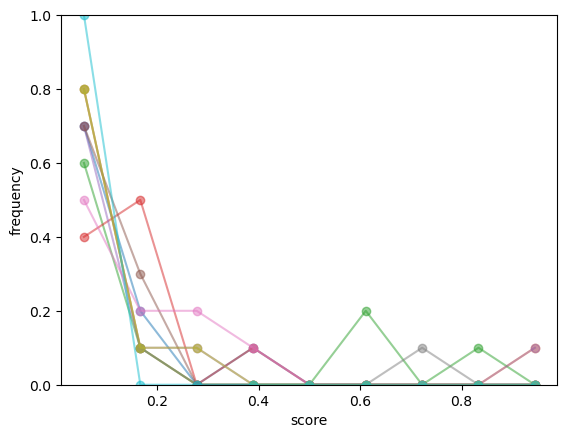

Estimated 1-alpha quantiles: [0.4217931516933866, 0.4306277854914636, 0.439097199012613, 0.5031112853285747, 0.5034343792670397, 0.5077561672690062, 0.5426000041519257, 0.5829346332019596, 0.597502651243204, 0.6051602459190188]
TRIAL 1


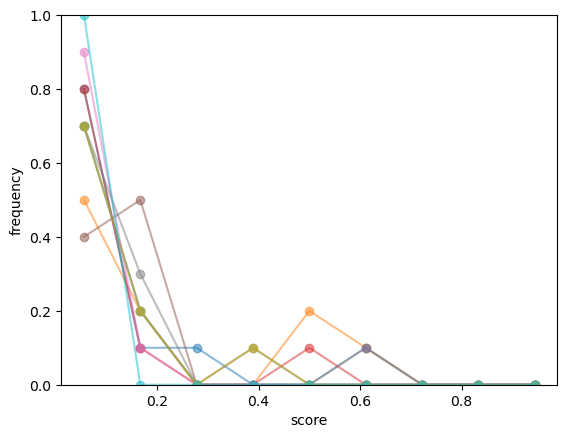

Estimated 1-alpha quantiles: [0.3071860683588079, 0.4395167045144004, 0.44238106155453133, 0.45650581540374324, 0.45862875441616735, 0.4888541407561659, 0.5428154230591027, 0.5512516370729199, 0.5802931716339348, 0.59715385471202]
TRIAL 2


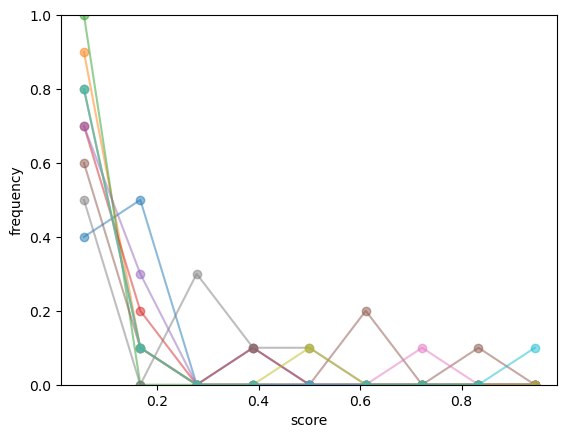

Estimated 1-alpha quantiles: [0.315554718609248, 0.3533916395861298, 0.3843365085322601, 0.47332339232870707, 0.4888541407561659, 0.5823736699598902, 0.5858600087492418, 0.5880728519386182, 0.5927784020669382, 0.6113595214799171]
TRIAL 3


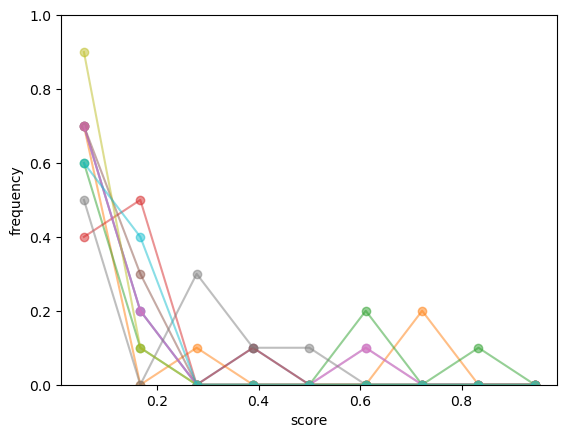

Estimated 1-alpha quantiles: [0.2901316239600249, 0.3033944227670441, 0.40411324913969326, 0.4163788840287846, 0.4172950110684091, 0.44877434106298614, 0.5427172093488971, 0.564925846002357, 0.6756197548802956, 0.705932501187845]
TRIAL 4


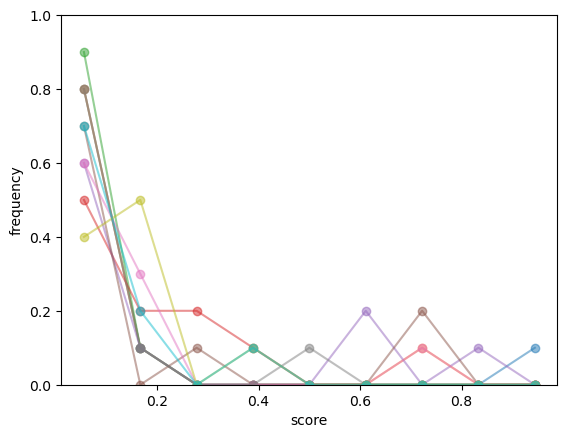

Estimated 1-alpha quantiles: [0.2607730261922984, 0.34214589476837637, 0.4294119413415666, 0.4749408405635697, 0.5084293240599295, 0.5171684413785974, 0.548432017156488, 0.5880728519386178, 0.6041243518078718, 0.6488541130712969]
TRIAL 5


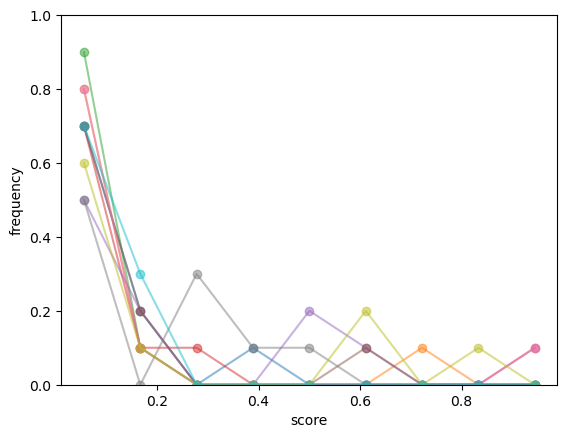

Estimated 1-alpha quantiles: [0.3328698431510765, 0.3352318230163859, 0.40602562327005565, 0.41717298118214907, 0.43421500658936407, 0.49901076514965254, 0.5114146835393721, 0.5397260922896715, 0.6437682863797481, 0.7121390687830758]
TRIAL 6


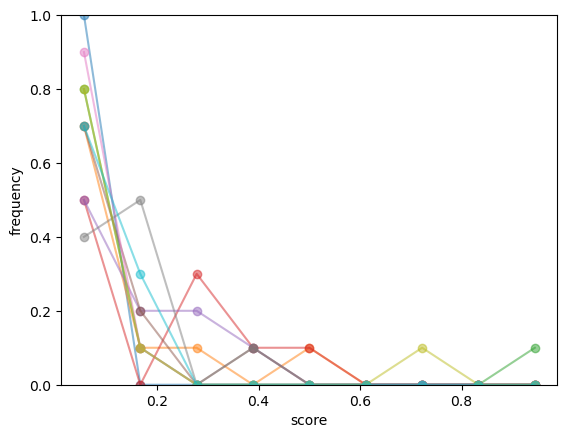

Estimated 1-alpha quantiles: [0.26189142396475146, 0.32856876278846525, 0.35339163958612974, 0.4610633499185223, 0.47106780634560824, 0.48933150037589745, 0.5077561672690061, 0.5482000312597295, 0.5674837533287556, 0.5823736699598903]
TRIAL 7


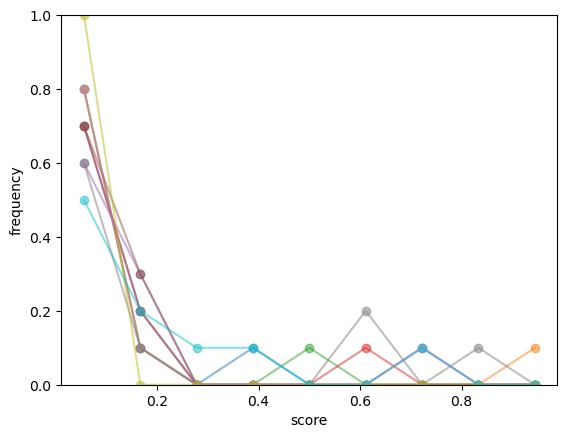

Estimated 1-alpha quantiles: [0.3110322374160269, 0.3884756437996595, 0.4187628570200911, 0.4347071539250974, 0.4566038470291686, 0.49456206629903043, 0.5209176078402047, 0.580643575852343, 0.5953440111924534, 0.7261959309359028]
TRIAL 8


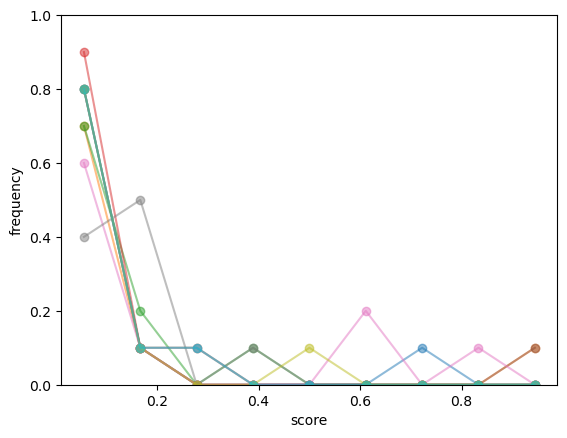

Estimated 1-alpha quantiles: [0.3397448541960897, 0.340898927613103, 0.41189353159350955, 0.4310626820298087, 0.45722333248759117, 0.49045037807967246, 0.5116282045588283, 0.5134868479761175, 0.542099252642428, 0.7202680883569059]
TRIAL 9


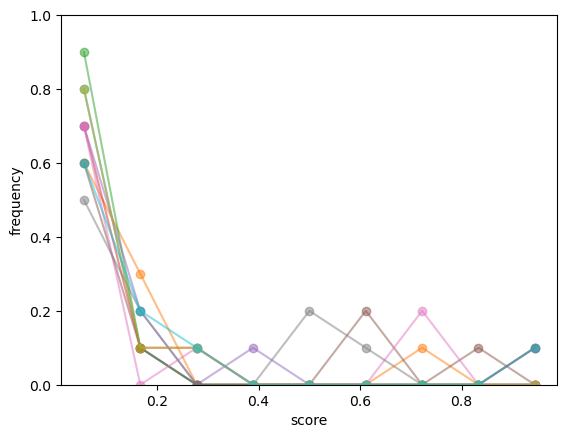

Estimated 1-alpha quantiles: [0.4325511123710043, 0.4386890056247942, 0.4520769320264697, 0.45655393631075647, 0.45689026302703306, 0.5050102276112178, 0.5077561672690063, 0.5539485714758691, 0.5678500196962438, 0.5935216333094707]


In [26]:
plot_random_cluster_scores_distrs(softmax_n10, labels_n10, num_trials, a, alpha=alpha, nbins=10)